In [1]:
RESET_PROJECT_FILES = True

if RESET_PROJECT_FILES:
  ! rm -rf DeepColor utils bash &&\
  git clone https://github.com/ArnoBen/DeepColor &&\
  mv DeepColor/* . &&\
  rm -rf DeepColor

Cloning into 'DeepColor'...
remote: Enumerating objects: 213, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 213 (delta 41), reused 57 (delta 24), pack-reused 137
Receiving objects: 100% (213/213), 157.18 MiB | 16.61 MiB/s, done.
Resolving deltas: 100% (97/97), done.
Checking out files: 100% (22/22), done.


In [ ]:
import os

RESET_IMAGE_FOLDER = False

if RESET_IMAGE_FOLDER:
  ! rm -r images/

if not os.path.isdir('images'):
  ! ./bash/download_extract_coco.sh

In [1]:
import os
import time
import datetime
import tensorflow as tf
import numpy as np
import cv2
from utils.dataset import make_dataset
from utils.conversions import rgb2lab, lab2rgb, bgr2rgb, bgr2lab, denormalize_lab
from utils.decomposition import decompose, recompose, decompose_generator
from keras.callbacks import TensorBoard, LearningRateScheduler, EarlyStopping
from tensorflow.keras.layers import Layer, Conv2D, LeakyReLU, BatchNormalization, ReLU, Conv2DTranspose, Dropout, Concatenate
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams["axes.spines.left"] = False
matplotlib.rcParams["axes.spines.bottom"] = False
matplotlib.rcParams["xtick.major.bottom"] = False
matplotlib.rcParams["ytick.major.left"] = False

# Pix2pix GAN implementation for image colorization

Architecture from [this tensorflow implementation](https://www.tensorflow.org/tutorials/generative/pix2pix) based on the [pix2pix paper](https://arxiv.org/abs/1611.07004).

## EDA and preprocessing

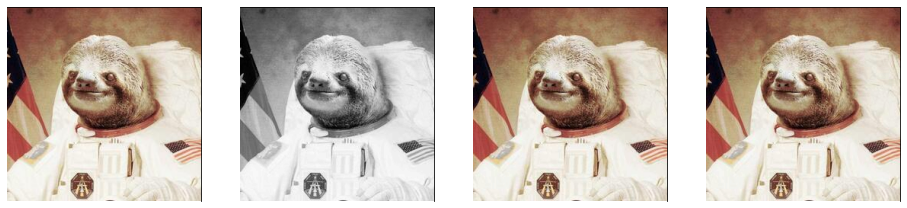

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(16, 5))
img = bgr2rgb(cv2.imread('sloth-256.jpg'))
ax[0].imshow(img);

img = rgb2lab(img)
L, ab = decompose(img)
ax[1].imshow(L[..., 0], cmap='gray');
ax[2].imshow(lab2rgb(img))

recomposed = recompose(L, ab)
ax[3].imshow(lab2rgb(recomposed))

L = tf.cast(L, tf.float32)
ab = tf.cast(ab, tf.float32)

## Generator

### Architecture

In [ ]:
OUTPUT_CHANNELS = 2

In [ ]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(Conv2D(filters, size, strides=2, padding='same',
                kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(BatchNormalization())

    result.add(LeakyReLU())

    return result

In [ ]:
down_model = downsample(3, 4)
down_result = down_model(L[tf.newaxis, ...])
print(down_result.shape)

(1, 128, 128, 3)


In [ ]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(Conv2DTranspose(filters, size, strides=2,
                                padding='same',
                                kernel_initializer=initializer,
                                use_bias=False))

    result.add(BatchNormalization())

    if apply_dropout:
        result.add(Dropout(0.5))

    result.add(ReLU())

    return result

In [ ]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 256, 256, 3)


In [ ]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 1])  # Lightness channel

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = Conv2DTranspose(OUTPUT_CHANNELS, 4,
                          strides=2,
                          padding='same',
                          kernel_initializer=initializer,
                          activation='tanh')  # (batch_size, 256, 256, 2)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

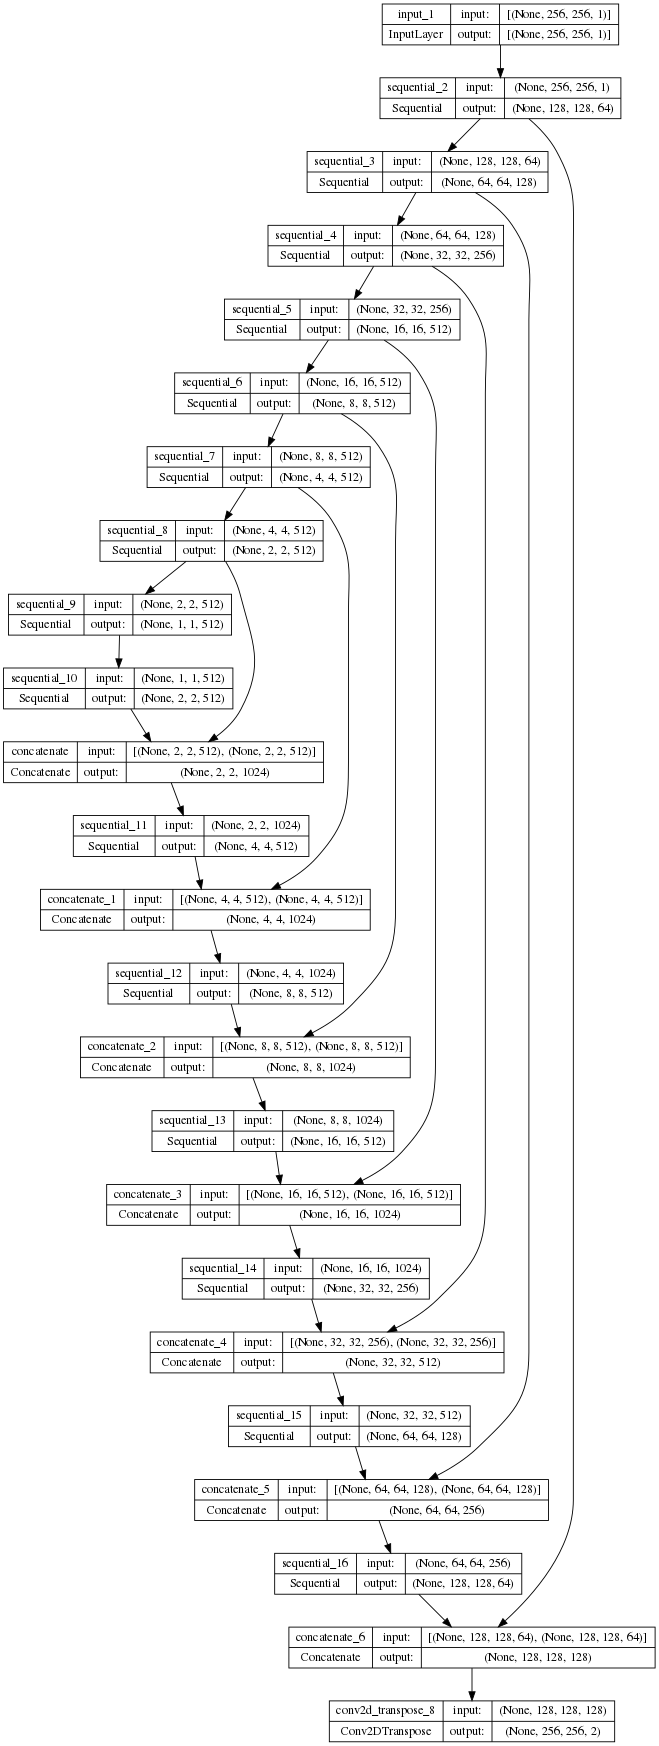

In [ ]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

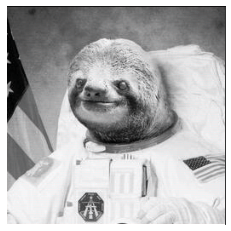

In [ ]:
gen_output = generator(L[tf.newaxis, ...], training=False)[0]
gen_lab = recompose(L, gen_output)
gen_output_rgb = lab2rgb(gen_lab)
plt.imshow(gen_output_rgb);

### Loss

GANs learn a loss that adapts to the data, while cGANs learn a structured loss that penalizes a possible structure that differs from the network output and the target image, as described in the pix2pix paper.

- The generator loss is a sigmoid cross-entropy loss of the generated images and an array of ones.
- The pix2pix paper also mentions the L1 loss, which is a MAE (mean absolute error) between the generated image and the target image.
- This allows the generated image to become structurally similar to the target image.
- The formula to calculate the total generator loss is `gan_loss + LAMBDA * l1_loss`, where `LAMBDA = 100`. This value was decided by the authors of the paper.

In [ ]:
LAMBDA = 100
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

## Discriminator

### Architecture

In [ ]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

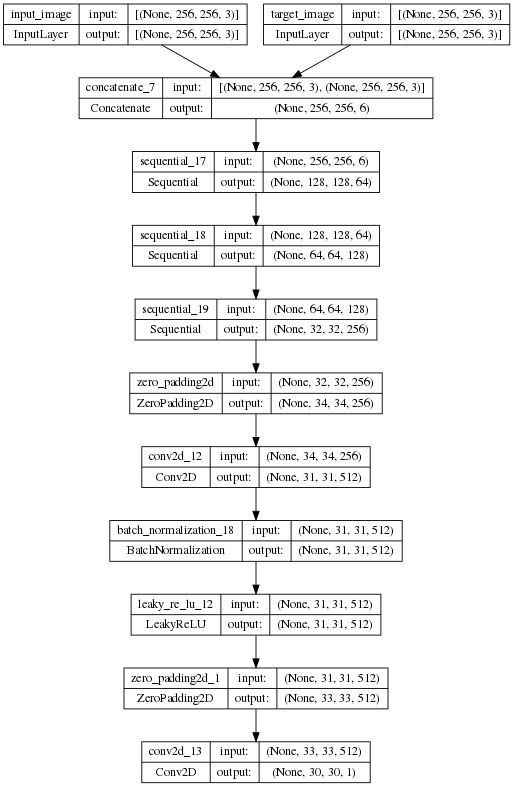

In [ ]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

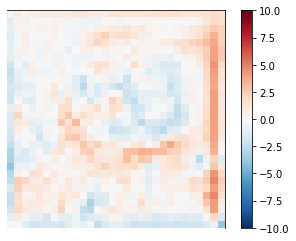

In [ ]:
disc_out = discriminator([img[tf.newaxis, ...], gen_lab[tf.newaxis, ...]], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-10, vmax=10, cmap='RdBu_r')
plt.colorbar();

### Loss

In [ ]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

## Setting up training

#### Optimizers and checkpoints

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### Generate images

Write a function to plot some images during training.

- Pass images from the test set to the generator.
- The generator will then translate the input image into the output.
- The last step is to plot the predictions and voila!

_Note: The training=True is intentional here since you want the batch statistics, while running the model on the test dataset. If you use training=False, you get the accumulated statistics learned from the training dataset (which you don't want)._

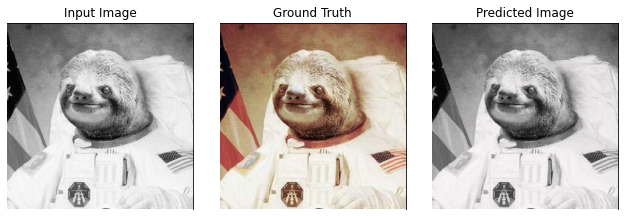

In [ ]:
def generate_images(model, target):
  L, _ = decompose(target)
  L = tf.cast(L, tf.float32)[tf.newaxis, ...]
  prediction = model(L, training=False)
  prediction_lab = recompose(L[0], prediction[0].numpy())
  fig, axes = plt.subplots(1, 3, figsize=(9, 3))
  titles = ['Input Image', 'Ground Truth', 'Predicted Image']

  axes[0].imshow(L[0][..., 0], cmap='gray')
  axes[1].imshow(lab2rgb(target))
  axes[2].imshow(lab2rgb(prediction_lab))

  for i, title in enumerate(titles):
    axes[i].set_title(title)
  plt.tight_layout()
  plt.show()


class GenerateImageCallback(tf.keras.callbacks.Callback):
    def __init__(self, target):
        """
        target: image in Lab colorspace
        """
        super(GenerateImageCallback, self).__init__()
        self.target = target

    def on_epoch_end(self, epoch, logs=None):
        generate_images(self.model, self.target)


img = bgr2lab(cv2.imread('sloth-256.jpg'))
generate_image_callback = GenerateImageCallback(img)
generate_images(Generator(), img)

## Training

### Pretraing the generator

In [ ]:
X = make_dataset(train_size=8000, val_size=2000, test_size=100)

Getting all images paths and removing greyscale images


100%|██████████| 100/100 [00:00<00:00, 661.58it/s]


Greyscale images may have been removed, hence the possibly smaller final size

 {'train': 7783, 'valid': 1953, 'test': 98}
Loading data in dictionary and converting to Lab colorspace.


100%|██████████| 98/98 [00:00<00:00, 295.98it/s]


Done.


In [ ]:
# Logs
log_dir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

# Tensorboard
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
# Early Stopping
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

# Learning rate scheduler
def scheduler(epoch, lr):
    # Decreases the lr exponentially every n epoch
    return lr * tf.math.exp(-0.1) if ((epoch != 0) and (epoch % 4 == 0)) else lr
    
lr_scheduler = LearningRateScheduler(scheduler)

In [ ]:
L = tf.cast(X['train'][:100, :, :, 0] / 50 - 1, tf.float32)
ab = tf.cast(X['train'][:100, :, :, 1:] / 127, tf.float32)
L_val = tf.cast(X['valid'][:100, :, :, 0] / 50 - 1, tf.float32)
ab_val = tf.cast(X['valid'][:100, :, :, 1:] / 127, tf.float32)

In [ ]:
img = bgr2lab(cv2.imread('sloth-256.jpg'))[np.newaxis, ...]
L = tf.cast(img[..., 0] / 50 - 1, tf.float32)
ab = tf.cast(img[..., 1:] / 127, tf.float32)

In [ ]:
L.numpy().min(), L.numpy().max(), ab.numpy().min(), ab.numpy().max()

(-1.0, 1.0, -0.11811024, 0.37007874)

In [ ]:
L_numpy = (img[..., 0] / 50 - 1).astype(np.float32)
ab_numpy = (img[..., 1:] / 127).astype(np.float32)

Epoch 1/10
1/1 [==============================] - ETA: 0s - loss: 0.1996

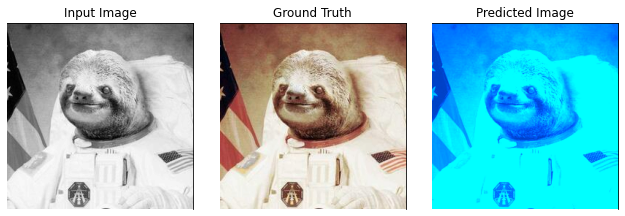

1/1 [==============================] - 3s 3s/step - loss: 0.1996 - val_loss: nan
Epoch 2/10
1/1 [==============================] - ETA: 0s - loss: 0.1631

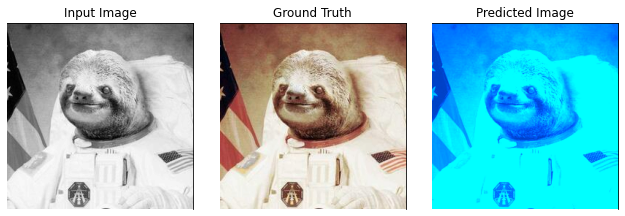

1/1 [==============================] - 1s 855ms/step - loss: 0.1631 - val_loss: nan
Epoch 3/10
1/1 [==============================] - ETA: 0s - loss: 0.1201

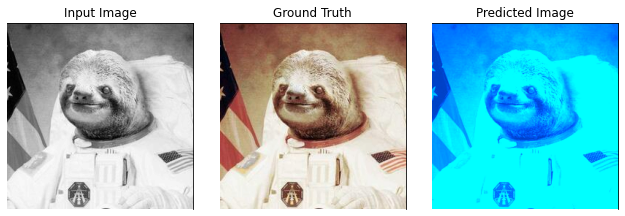

1/1 [==============================] - 1s 854ms/step - loss: 0.1201 - val_loss: nan
Epoch 4/10
1/1 [==============================] - ETA: 0s - loss: 0.0892

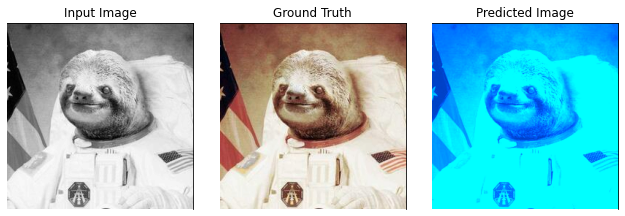

1/1 [==============================] - 1s 813ms/step - loss: 0.0892 - val_loss: nan
Epoch 5/10
1/1 [==============================] - ETA: 0s - loss: 0.0715

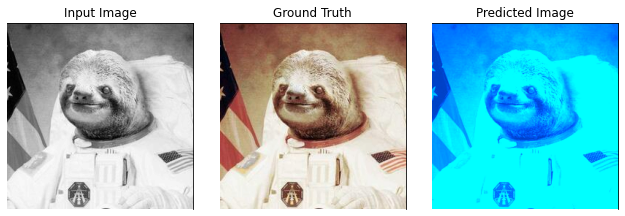

1/1 [==============================] - 1s 846ms/step - loss: 0.0715 - val_loss: nan
Epoch 6/10
1/1 [==============================] - ETA: 0s - loss: 0.0588

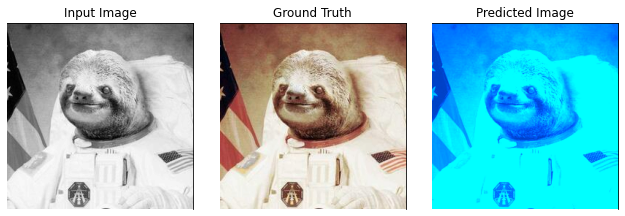

1/1 [==============================] - 1s 854ms/step - loss: 0.0588 - val_loss: nan
Epoch 7/10
1/1 [==============================] - ETA: 0s - loss: 0.0536

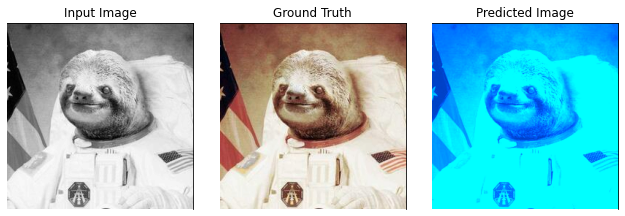

1/1 [==============================] - 19s 19s/step - loss: 0.0536 - val_loss: nan
Epoch 8/10
1/1 [==============================] - ETA: 0s - loss: 0.0508

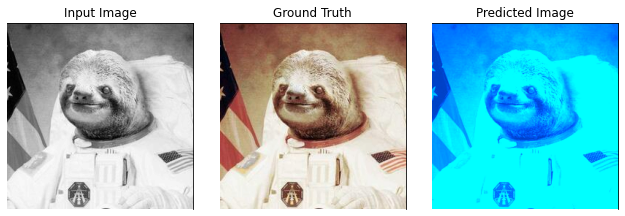

1/1 [==============================] - 1s 870ms/step - loss: 0.0508 - val_loss: nan
Epoch 9/10
1/1 [==============================] - ETA: 0s - loss: 0.0416

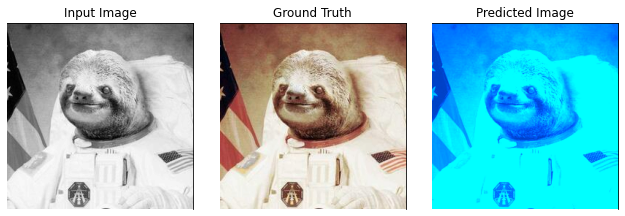

1/1 [==============================] - 1s 850ms/step - loss: 0.0416 - val_loss: nan
Epoch 10/10
1/1 [==============================] - ETA: 0s - loss: 0.0354

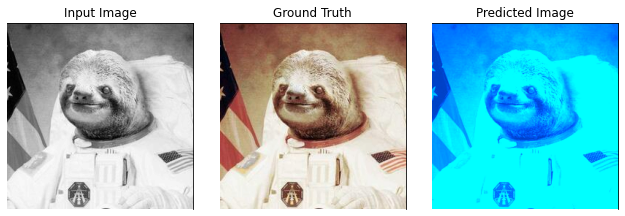

1/1 [==============================] - 1s 835ms/step - loss: 0.0354 - val_loss: nan


In [ ]:
generator = Generator()
generator.compile(optimizer=generator_optimizer, loss=tf.keras.losses.MeanAbsoluteError())
EPOCHS = 10

generator.fit(
            x=L, y=ab,
            validation_data=(L, ab), 
            epochs=EPOCHS,
            callbacks=[generate_image_callback], 
            verbose=1,
        )

In [ ]:
generator.evaluate(L, ab)

1/1 [==============================] - 0s 45ms/step - loss: nan


nan

In [ ]:
generator.predict(L)

1/1 [==============================] - 1s 1s/step


array([[[[nan, nan],
         [nan, nan],
         [nan, nan],
         ...,
         [nan, nan],
         [nan, nan],
         [nan, nan]],

        [[nan, nan],
         [nan, nan],
         [nan, nan],
         ...,
         [nan, nan],
         [nan, nan],
         [nan, nan]],

        [[nan, nan],
         [nan, nan],
         [nan, nan],
         ...,
         [nan, nan],
         [nan, nan],
         [nan, nan]],

        ...,

        [[nan, nan],
         [nan, nan],
         [nan, nan],
         ...,
         [nan, nan],
         [nan, nan],
         [nan, nan]],

        [[nan, nan],
         [nan, nan],
         [nan, nan],
         ...,
         [nan, nan],
         [nan, nan],
         [nan, nan]],

        [[nan, nan],
         [nan, nan],
         [nan, nan],
         ...,
         [nan, nan],
         [nan, nan],
         [nan, nan]]]], dtype=float32)

In [ ]:
generator(L, training=True)

<tf.Tensor: shape=(1, 256, 256, 2), dtype=float32, numpy=
array([[[[-0.02235029,  0.05258559],
         [-0.02153547,  0.09111562],
         [-0.0054885 ,  0.07812459],
         ...,
         [ 0.03164434,  0.14627236],
         [ 0.06169925,  0.08135677],
         [ 0.03772173,  0.00210342]],

        [[ 0.04256356,  0.06788196],
         [ 0.07094894,  0.03045413],
         [ 0.04400092, -0.01079729],
         ...,
         [ 0.10495431,  0.1321769 ],
         [ 0.10726382,  0.08101036],
         [ 0.06118713,  0.11606608]],

        [[ 0.00174195,  0.0442506 ],
         [ 0.09665163,  0.06792521],
         [ 0.14027196,  0.04630038],
         ...,
         [ 0.13925177,  0.1526789 ],
         [ 0.1725574 ,  0.10925603],
         [ 0.02679114,  0.04279545]],

        ...,

        [[-0.02531576,  0.04048995],
         [ 0.03146558,  0.07093873],
         [-0.01707833,  0.01046402],
         ...,
         [ 0.0098971 ,  0.10185901],
         [ 0.00750964,  0.08962302],
         [ 0.04

In [ ]:
ab_pred = generator(L, training=True)
print(ab_pred)
# tf.keras.losses.MeanAbsoluteError()(ab_numpy, ab_pred)

tf.Tensor(
[[[[ 0.01248165  0.02980856]
   [ 0.00586026  0.06978907]
   [ 0.06635232  0.020067  ]
   ...
   [ 0.02835658  0.08128842]
   [ 0.05511591  0.07229814]
   [ 0.04102737  0.04062274]]

  [[ 0.0319794   0.0709139 ]
   [ 0.05890622  0.06416139]
   [ 0.0874577   0.07930157]
   ...
   [ 0.14165223  0.08725674]
   [ 0.10174433  0.11598106]
   [ 0.00924767  0.09740701]]

  [[ 0.06441317  0.09231126]
   [ 0.11602166  0.08050029]
   [ 0.16718286  0.06269191]
   ...
   [ 0.17481448  0.16756335]
   [ 0.08687796  0.15524688]
   [ 0.09672865 -0.01978021]]

  ...

  [[ 0.06062652  0.07174989]
   [ 0.01971171  0.14918487]
   [ 0.01753201  0.15123051]
   ...
   [ 0.02048215  0.1433531 ]
   [ 0.0036686   0.13907711]
   [-0.01363993  0.10748563]]

  [[-0.01388307  0.09101499]
   [ 0.02459504  0.1348496 ]
   [ 0.01688187  0.13423939]
   ...
   [ 0.02136521  0.13872997]
   [ 0.03434421  0.14040639]
   [ 0.04205874  0.06615198]]

  [[ 0.03777633  0.021367  ]
   [ 0.00932648  0.04470871]
   [ 0.04

Epoch 1/4
 6/32 [====>.........................] - ETA: 11s - loss: 0.1387

32/32 [==============================] - ETA: 0s - loss: 0.0951

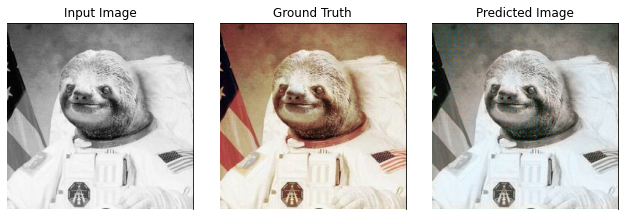

32/32 [==============================] - 37s 982ms/step - loss: 0.0951 - val_loss: 0.0800 - lr: 2.0000e-04
Epoch 2/4
32/32 [==============================] - ETA: 0s - loss: 0.0801

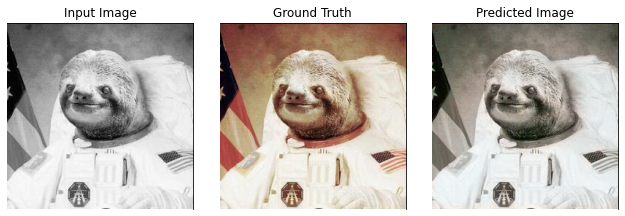

32/32 [==============================] - 28s 891ms/step - loss: 0.0801 - val_loss: nan - lr: 2.0000e-04
Epoch 3/4
 6/32 [====>.........................] - ETA: 12s - loss: 0.0767

KeyboardInterrupt: ignored

In [ ]:
generator = Generator()
BATCH_SIZE = 64
EPOCHS = 4
generator.compile(optimizer=generator_optimizer, loss=tf.keras.losses.MeanAbsoluteError())

history = generator.fit(
            x=L, y=ab,
            validation_data=(L, ab), 
            epochs=EPOCHS,
            batch_size=BATCH_SIZE
            callbacks=[tensorboard_callback, lr_scheduler, early_stopping, generate_image_callback], 
            verbose=1,
        )

In [ ]:
generator = Generator()
BATCH_SIZE = 2
EPOCHS = 2
steps_per_epoch = X['train'].shape[0] // BATCH_SIZE
validation_steps = X['valid'].shape[0]

generator.compile(optimizer=generator_optimizer, loss=tf.keras.losses.MeanAbsoluteError())

history = generator.fit(
            decompose_generator(X['train'], batch_size=BATCH_SIZE), 
            steps_per_epoch=steps_per_epoch, 
            validation_data=decompose_generator(X['valid']), 
            validation_steps=validation_steps, 
            epochs=EPOCHS,
            callbacks=[tensorboard_callback, lr_scheduler, early_stopping, generate_image_callback], 
            verbose=1,
        )

# Saving generator weights
best_val_loss_index = np.argmin(history.history['val_loss'])
best_val_loss = history.history['val_loss'][best_val_loss_index]
weights_path = f'weights/weights_gan_{best_val_loss:.4f}'.lower()
generator.save_weights(weights_path)

In [ ]:
history.history['val_loss']

[0.03810087963938713, nan]

### Training the whole GAN

In [ ]:
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [ ]:
@tf.function
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output_ab = generator(input_image, training=True)
    # Concatenating the ab output with the L channel
    gen_output_lab = tf.concat([input_image, gen_output_ab], axis=-1)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output_lab], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
    tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

In [ ]:
def fit(train_ds, test_ds, steps):
  example_input, example_target = next(iter(test_ds.take(1)))
  start = time.time()

  for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
    if (step) % 1000 == 0:
      display.clear_output(wait=True)

      if step != 0:
        print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

      start = time.time()

      generate_images(generator, example_input, example_target)
      print(f"Step: {step//1000}k")

    train_step(input_image, target, step)

    # Training step
    if (step+1) % 10 == 0:
      print('.', end='', flush=True)


    # Save (checkpoint) the model every 5k steps
    if (step + 1) % 5000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

In [ ]:
fit(decompose_generator(X['train']), decompose_generator(X['valid']), steps=4)


AttributeError: ignored

# Other tutorial

https://machinelearningmastery.com/how-to-implement-pix2pix-gan-models-from-scratch-with-keras/

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate (Concatenate)      (None, 256, 256, 6)  0           ['input_1[0][0]',                
                                                                  'input_2[0][0]']            

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


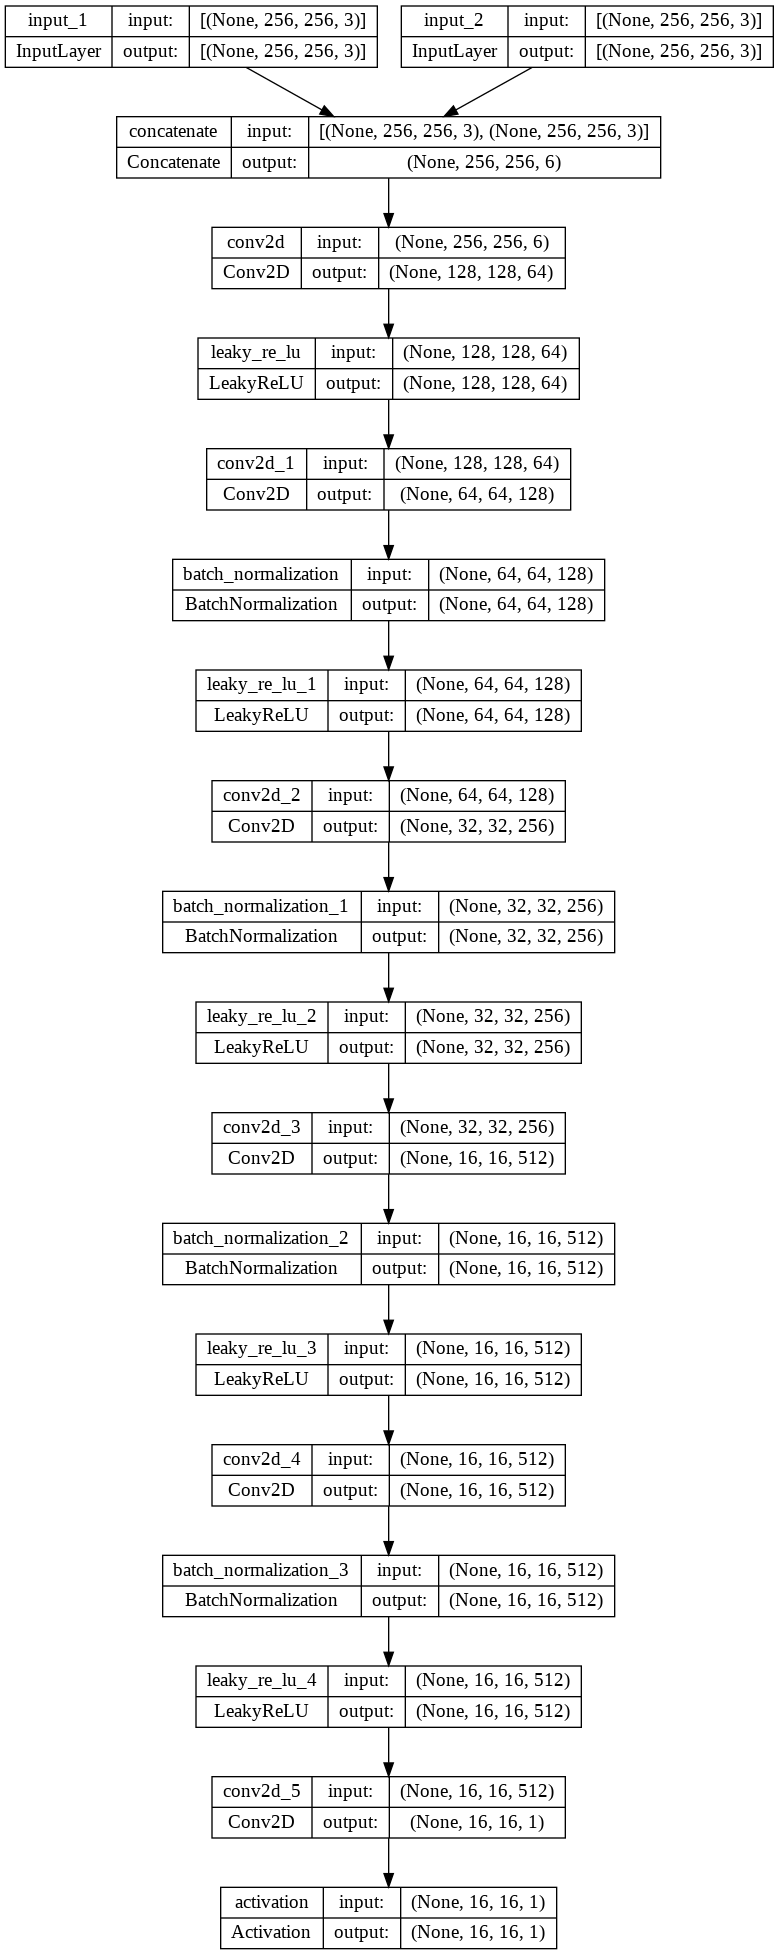

In [2]:
# example of defining a 70x70 patchgan discriminator model
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import BatchNormalization
from keras.layers import Lambda
from keras.layers import Reshape
from keras.utils.vis_utils import plot_model

# define the discriminator model
def define_discriminator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_src_image = Input(shape=image_shape)
	# target image input
	in_target_image = Input(shape=image_shape)
	# concatenate images channel-wise
	merged = Concatenate()([in_src_image, in_target_image])
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)
	# define model
	model = Model([in_src_image, in_target_image], patch_out)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
	return model

# define image shape
image_shape = (256,256,3)
# create the model
model = define_discriminator(image_shape)
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='discriminator_model_plot.png', show_shapes=True, show_layer_names=True)

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_2 (Lambda)              (None, 256, 256, 1)  0           ['input_8[0][0]']                
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 256, 256, 1)  0           ['lambda_2[0][0]']               
                                                                                                  
 tf.math.subtract (TFOpLambda)  (None, 256, 256, 1)  0           ['tf.math.truediv[0][0]']  

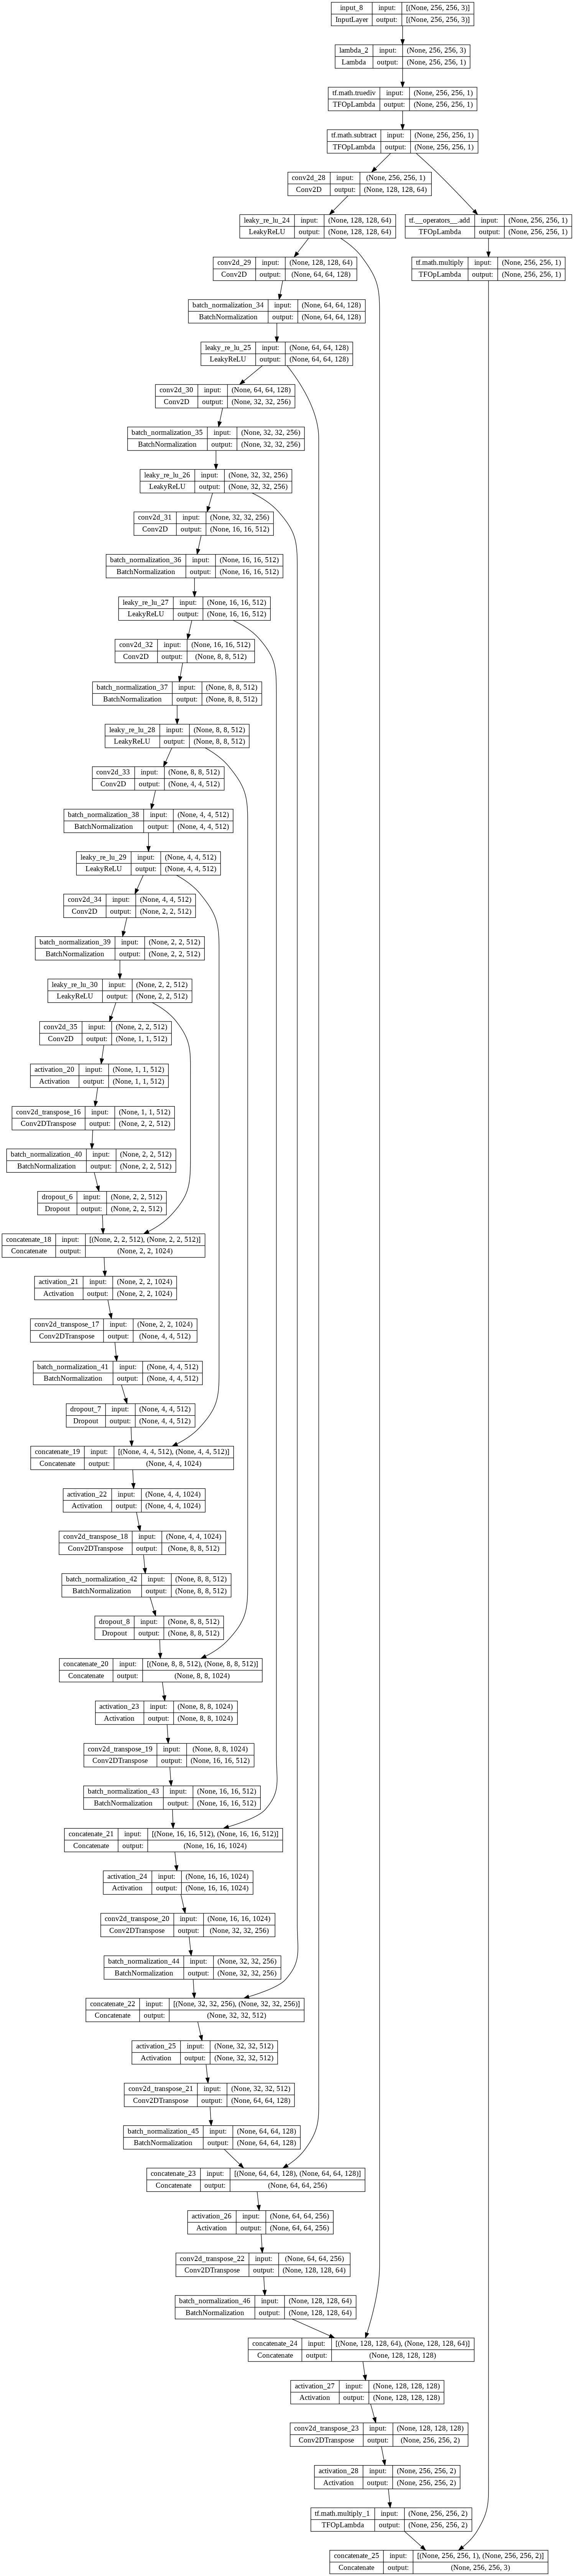

In [9]:
# example of defining a u-net encoder-decoder generator model

# define an encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add downsampling layer
	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# conditionally add batch normalization
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	# leaky relu activation
	g = LeakyReLU(alpha=0.2)(g)
	return g

# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add upsampling layer
	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# add batch normalization
	g = BatchNormalization()(g, training=True)
	# conditionally add dropout
	if dropout:
		g = Dropout(0.5)(g, training=True)
	# merge with skip connection
	g = Concatenate()([g, skip_in])
	# relu activation
	g = Activation('relu')(g)
	return g

# define the standalone generator model
def define_generator(image_shape=(256,256,3)):
    """
    Input image is a NOT normalized Lab image
    """
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=image_shape)
    # Splitting L and ab channel
    L_channel = Lambda(lambda x: x[..., 0][..., tf.newaxis], input_shape=image_shape)(in_image)
    ab_channels = Lambda(lambda x: x[..., 1:][..., tf.newaxis], input_shape=image_shape)(in_image)
    # Normalizing inputs
    L_channel = L_channel / 50 - 1
    ab_channels /= 127
    
    # encoder model: C64-C128-C256-C512-C512-C512-C512-C512
    e1 = define_encoder_block(L_channel, 64, batchnorm=False)
    e2 = define_encoder_block(e1, 128)
    e3 = define_encoder_block(e2, 256)
    e4 = define_encoder_block(e3, 512)
    e5 = define_encoder_block(e4, 512)
    e6 = define_encoder_block(e5, 512)
    e7 = define_encoder_block(e6, 512)
    # bottleneck, no batch norm and relu
    b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
    b = Activation('relu')(b)
    # decoder model: CD512-CD1024-CD1024-C1024-C1024-C512-C256-C128
    d1 = decoder_block(b, e7, 512)
    d2 = decoder_block(d1, e6, 512)
    d3 = decoder_block(d2, e5, 512)
    d4 = decoder_block(d3, e4, 512, dropout=False)
    d5 = decoder_block(d4, e3, 256, dropout=False)
    d6 = decoder_block(d5, e2, 128, dropout=False)
    d7 = decoder_block(d6, e1, 64, dropout=False)
    # output
    g = Conv2DTranspose(2, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
    out_ab = Activation('tanh')(g)
    # Denormalizing
    L_channel = (L_channel + 1) * 50
    out_ab *= 127
    out_Lab = Concatenate()([L_channel, out_ab])
    # define model
    model = Model(in_image, out_Lab)
    return model

# define image shape
image_shape = (256,256,3)
# create the model
model = define_generator(image_shape)
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='generator_model_plot.png', show_shapes=True, show_layer_names=True)

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_6 (Functional)           (None, 256, 256, 3)  54425218    ['input_12[0][0]']               
                                                                                                  
 model_7 (Functional)           (None, 16, 16, 1)    6968257     ['input_12[0][0]',               
                                                                  'model_6[0][0]']                
                                                                                            

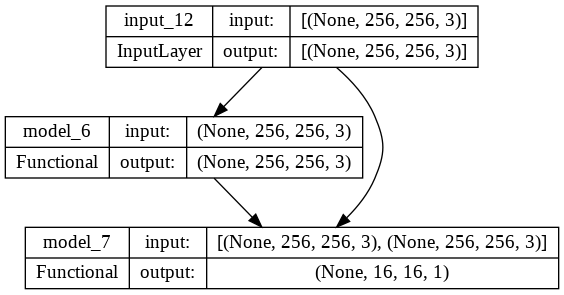

In [10]:
def define_gan(g_model, d_model, image_shape):
	# make weights in the discriminator not trainable
	for layer in d_model.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False
	# define the source image
	in_src = Input(shape=image_shape)
	# connect the source image to the generator input
	gen_out = g_model(in_src)
	# connect the source input and generator output to the discriminator input
	dis_out = d_model([in_src, gen_out])
	# src image as input, generated image and classification output
	model = Model(in_src, [dis_out, gen_out])
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
	return model

# define image shape
image_shape = (256,256,3)
#define the models
g_model = define_generator(image_shape)
d_model = define_discriminator(image_shape)
# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)
# summarize the model
gan_model.summary()
# plot the model
plot_model(gan_model, to_file='gan_model_plot.png', show_shapes=True, show_layer_names=True)

In [11]:
# train pix2pix models
def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1, n_patch=16):
	# unpack dataset
	trainA, trainB = dataset
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# manually enumerate epochs
	for i in range(n_steps):
		# select a batch of real samples
		[X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
		# generate a batch of fake samples
		X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
		# update discriminator for real samples
		d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
		# update discriminator for generated samples
		d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
		# update the generator
		g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
		# summarize performance
		print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))

In [12]:
tf.config.run_functions_eagerly(True)

In [13]:
def normalize_lab(img):
  normalized = np.zeros(img.shape)
  normalized[..., 0] = img[..., 0] / 50 - 1
  normalized[..., 1:] = img[..., 1:] / 127
  return normalized

In [27]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
g_model = define_generator()
g_model.compile(optimizer=generator_optimizer, loss="mae")
img = bgr2lab(cv2.imread('sloth-256.jpg'))
for i in range(20):
  g_model.fit(img[np.newaxis, ...], img[np.newaxis, ...])

1/1 [==============================] - 0s 90ms/step - loss: 2.5124


1/1 [==============================] - 0s 49ms/step


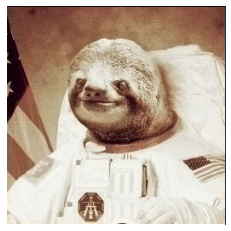

In [28]:
output = g_model.predict(img[np.newaxis, ...])
plt.imshow(lab2rgb(output[0]))

In [8]:
X = make_dataset(10000, 1000, 100)

Getting all images paths and removing greyscale images


100%|██████████| 100/100 [00:00<00:00, 709.32it/s]


Greyscale images may have been removed, hence the possibly smaller final size

 {'train': 9732, 'valid': 975, 'test': 97}
Loading data in dictionary and converting to Lab colorspace.


100%|██████████| 97/97 [00:00<00:00, 177.43it/s]


Done.


In [29]:
X['train'].shape

(9732, 256, 256, 3)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
g_model = define_generator()
g_model.compile(optimizer=generator_optimizer, loss="mae")
for i in range(20):
  g_model.fit(X['train'], X['train'], 
              validation_data=(X['valid'], X['valid']),
              batch_size=64
              )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


In [35]:
output = g_model.predict(img[tf.newaxis])

1/1 [==============================] - 0s 49ms/step


In [43]:
output[0][..., 2].max()

21.113176

In [47]:
output = g_model.predict(X['train'][0][tf.newaxis])

1/1 [==============================] - 0s 78ms/step


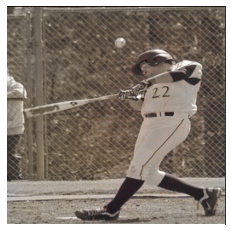

In [48]:
plt.imshow(lab2rgb(output[0].astype(int)))